In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def log_return(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [3]:
def log_volume(series):
    log_return = np.log(series / series.shift(1)).dropna()
    return log_return

In [4]:
def bipower_variation(series, rollingWindow=5):
    '''
    Bipower Variation (BV) is the sum of the product of absolute time series returns
    :param column: price column
    :return: returns bivariate variation
    Barnhorf - Nielse & Shephard 2004 & 2006
    '''
    bv = (series.abs() *series.shift(1).abs()).dropna().rolling(rollingWindow).sum()
    
    return bv

In [5]:
def volatility_increments(series):
    theta = np.sqrt(series)
    Vt = (np.log(theta) - np.log(theta.shift(1))).dropna()
    return Vt

In [6]:
#################################################
# codes for implementing DFA-based analysis
# Exploring asymmetric multifractal cross-correlations of price-volatility and asymmetric volatility dynamics in cryptocurrency markets
#################################################
import numpy as np
import math
###########################################
# MF-ADCCA (includes DFA, DCCA, A-DFA, A-DCCA, MFDFA, MFDCCA, A-MFDFA)
##########################################

import numpy as np

def dcca(x, y, S, m, Q, trend_base=None, skip_agg=False, asymmetry_base='index'):
    """
    Calculate generalized Hurst Exponenet by Multi Fractal Detrended Cross-correlation Analysis.
    Args:
        x(array(float))  : Target time series data.
        y(array(float))  : Target time series data.
        S(array(int))    : Intervals which divides culmative sum time series. Needs to be a positive integer.
        m(int)           : Degree of polynomial fit for each divided segment. Generally, m=2 is recommended.
        Q(array(int))    : fluctuation q-th order.
        trend_base       : designated time series used for defining asymmetric trends.
        skip_agg(bool)   : Whether to use cumsum for profile. If series is stationary (ex. log-returns), then "False". If non-stationary (ex. level data), then "True".
                           It's not needed.
        asymmetry_base  : Which criterion used for defining asymmetric trends.
    Returns:
        array(float)     : Return generalized Hurst exponent (in np.array) of each Q-th order.
    """
    N = len(x)
    assert len(y) == N, '{} segments'.format(len(y))
    if skip_agg:
        X = np.copy(x)
        Y = np.copy(y)
    else:
        X = np.cumsum(x - np.mean(x))
        Y = np.cumsum(y - np.mean(y))

    def Fvs2(v, s, reverse=False):
        """
        (Root Mean Square) ** 2
        F(s, v)
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment_x = X[N - (v-Ns)*s:N - (v-Ns)*s+s]
            segment_y = Y[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment_x = X[(v-1)*s:v*s]
            segment_y = Y[(v-1)*s:v*s]
        coef_x = np.polyfit(ax, segment_x, m)
        coef_y = np.polyfit(ax, segment_y, m)
        fitting_x = np.polyval(coef_x, ax)
        fitting_y = np.polyval(coef_y, ax)
        return np.mean(np.abs(segment_x - fitting_x)*np.abs(segment_y - fitting_y)) # DCCA for x and y

    if asymmetry_base == 'index':
        x_alt = np.exp(np.cumsum(x)) # index-based
    elif asymmetry_base == 'return':
        x_alt = np.copy(x) # return-based
    elif asymmetry_base == 'optional':
        assert type(trend_base) == np.ndarray, 'trend_base is None. designate trend_base.'
        x_alt = np.copy(trend_base) # only for optional. Any series is possible, but designate trend_base.
    else:
        print('not available: index or return or optional only\nPlease choose either and try again')

    def asym_trend(v, s, reverse=False):
        """
        Detecting trend in some data series H
        L_H(x)=a_H+b_H x
        """
        Ns = int(N//s)
        ax = np.arange(1, s+1)
        if reverse:
            segment = x_alt[N - (v-Ns)*s:N - (v-Ns)*s+s]
        else:
            segment = x_alt[(v-1)*s:v*s]
        coef = np.polyfit(ax, segment, 1) # m=1, y=ax+b (a,b)
        return coef[0] # represents a in y=ax+b

    Fhq = np.zeros(len(Q))
    Fhq_plus = np.zeros(len(Q))
    Fhq_minus = np.zeros(len(Q))
    
    for i, q in enumerate(Q):
        Fqs = np.zeros(len(S))
        Fqs_plus = np.zeros(len(S))
        Fqs_minus = np.zeros(len(S))

        for j, s in enumerate(S):
            Ns = int(N//s)
            segs = np.array([
                [Fvs2(v, s) for v in range(1, Ns + 1)],
                [Fvs2(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(segs) == 2 * Ns, '{} segments'.format(len(segs))

            trend_segs = np.array([
                [asym_trend(v, s) for v in range(1, Ns + 1)],
                [asym_trend(v, s, reverse=True) for v in range(Ns+1, 2 * Ns + 1)]
            ]).reshape(-1)

            assert len(trend_segs) == 2 * Ns, '{} segments'.format(len(trend_segs))

            M_plus = np.sum((1+np.sign(trend_segs))/2)
            M_minus = np.sum((1-np.sign(trend_segs))/2)

            # calculate qth fluctuation function
            if q == 0:
                # asymmetric version
                Fqs_plus[j] = np.exp((np.sum(((1+np.sign(trend_segs))/2)*np.log(segs))/M_plus)/2)
                Fqs_minus[j] = np.exp((np.sum(((1-np.sign(trend_segs))/2)*np.log(segs))/M_minus)/2)
                # overall
                Fqs[j] = np.exp(np.mean(np.log(segs))/2)
            else:
                # asymmetric version
                Fqs_plus[j] = (np.sum(((1+np.sign(trend_segs))/2)*(segs ** (q/2))) /M_plus)**(1/q)
                Fqs_minus[j] = (np.sum(((1-np.sign(trend_segs))/2)*(segs ** (q/2)))/M_minus)**(1/q)
                # overall version
                Fqs[j] = np.mean(segs ** (q/2)) ** (1/q)

        coef_plus = np.polyfit(np.log(S), np.log(Fqs_plus), 1)
        coef_minus = np.polyfit(np.log(S), np.log(Fqs_minus), 1)
        coef = np.polyfit(np.log(S), np.log(Fqs), 1)
        Fhq_plus[i] = coef_plus[0]
        Fhq_minus[i] = coef_minus[0]
        Fhq[i] = coef[0]

    # 1~2: estimates for overall trend, 4~5: estimates for positive trend, 7~8: estimates for negative trend
    # S: scales, Fqs: fluctuation functions, Fhq: generalized hurst exponent
    return S, Fqs, Fhq, S, Fqs_plus, Fhq_plus, S, Fqs_minus, Fhq_minus

def basic_dcca(x, y, Q, m=2, trend_base=None, skip_agg=False, observations=100, asymmetry_base='index'):
    """
    polynominal fitting is set to m = 2 at default
    """
    N = len(x)
    s_min = max(20, int(np.floor(N/100)))
    s_max = min(20*s_min, int(np.floor(N/10)))
    s_inc = (s_max - s_min) / (observations-1)
    S = [s_min + int(np.floor(i*s_inc)) for i in range(0, observations)]
    return dcca(x, y, S=S, m=m, Q=Q, trend_base=trend_base, skip_agg=skip_agg, asymmetry_base=asymmetry_base)

def nonlinear_detrend(segment, degree=2):
    """
    Nonlinear detrending using local polynomial regression.
    Args:
        segment (np.array): Segment of the time series.
        degree (int): Degree of the polynomial regression (e.g., 2 for quadratic).
    Returns:
        np.array: Detrended segment.
    """
    n = len(segment)
    x = np.arange(n)
    
    # Fit a polynomial regression
    coefficients = np.polyfit(x, segment, degree)
    
    # Calculate the trend using the polynomial coefficients
    trend = np.polyval(coefficients, x)
    
    # Remove the trend from the segment
    detrended_segment = segment - trend
    
    return detrended_segment

def MFADCCA_Hurst(X, Y, T=252, step=1, Q=np.array([2]), trend_base=None, skip_agg=False, observations=100, asymmetry_base='return'):
    X = np.array(X)
    nX = X.shape[0]
    hurst = np.zeros(nX-T+1)
    hurst_plus = np.zeros(nX-T+1)
    hurst_minus = np.zeros(nX-T+1)
    
    for i in range(0, nX-T+1, step):
        XX = X[i:i+T]
        YY = Y[i:i+T]
        
        # Apply nonlinear detrending to the segments
        XX_detrended = nonlinear_detrend(XX)
        YY_detrended = nonlinear_detrend(YY)
        
        MFADCCA_Hurst = basic_dcca(XX_detrended, YY_detrended, Q=Q, trend_base=trend_base, skip_agg=skip_agg, observations=observations, asymmetry_base=asymmetry_base)
        hurst[i] = MFADCCA_Hurst[2]
        hurst_plus[i] = MFADCCA_Hurst[5]
        hurst_minus[i] = MFADCCA_Hurst[8]
    
    return hurst, hurst_plus, hurst_minus



In [7]:
# read data_set and split them
dataset = pd.read_csv(r"./Datasets/FTSE/FTSE_QPL.csv")
df = dataset.reset_index(drop=True)
df = df.head(2515)

Close = df['Close']
Volume = df['vol']
# compute Log return and bipower variation for MFADCCA
LogReturn = log_return(Close)         # X
Bv = bipower_variation(LogReturn)     # Y
Vt = volatility_increments(Bv)
vol =  log_volume(Volume) 

Q = np.array([2])

df['log_returns'] = LogReturn         # add to df
df['volatility_increments'] = Vt
df['log_volumes'] = vol

In [8]:
data = df.dropna(axis=0, how='any')

r = data["log_returns"]
v = data["volatility_increments"]
vol = data['log_volumes']

data

Unnamed: 0        Date     Open     High      Low    Close        QPLp1  \
7            7.0   2012/1/12  5670.82  5699.57  5640.30  5662.42  5681.080334   
8            8.0   2012/1/13  5662.42  5709.22  5583.45  5636.64  5672.665135   
9            9.0   2012/1/16  5636.64  5662.88  5609.87  5657.44  5646.838491   
10          10.0   2012/1/17  5657.44  5724.41  5657.44  5693.95  5667.676125   
11          11.0   2012/1/18  5693.95  5709.87  5647.92  5702.37  5704.252183   
...          ...         ...      ...      ...      ...      ...          ...   
1509      1509.0  2017/12/19  7537.01  7563.49  7534.08  7544.09  7550.646870   
1510      1510.0  2017/12/20  7544.09  7550.60  7511.45  7525.22  7557.739680   
1511      1511.0  2017/12/21  7525.22  7609.69  7517.88  7603.98  7538.835539   
1512      1512.0  2017/12/22  7603.98  7614.40  7585.47  7592.66  7617.738041   
1513      1513.0  2017/12/27  7592.66  7632.71  7586.42  7620.68  7606.397559   

            QPLp2        QPLp3        QPLp4  ...       QPLn16       QPLn17  \
7     5705.073501  5734.743030  5768.010344  ...  5084.635031  5040.438773   
8     5696.622763  5726.248343  5759.466379  ...  5077.103328  5032.972536   
9     5670.687043  5700.177744  5733.244544  ...  5053.988171  5010.058299   
10    5691.612682  5721.212207  5754.401028  ...  5072.638104  5028.546124   
11    5728.343214  5758.133758  5791.536762  ...  5105.374114  5060.997590   
...           ...          ...          ...  ...          ...          ...   
1509  7582.535864  7621.969233  7666.184369  ...  6757.919503  6699.178855   
1510  7589.658630  7629.129041  7673.385711  ...  6764.267653  6705.471827   
1511  7570.674649  7610.046333  7654.192304  ...  6747.348219  6688.699459   
1512  7649.910384  7689.694137  7734.302146  ...  6817.966905  6758.704318   
1513  7638.522007  7678.246535  7722.788136  ...  6807.817038  6748.642675   

           QPLn18       QPLn19       QPLn20       QPLn21      vol  \
7     4996.166045  4951.871863  4907.605538  4863.411329  1380.00   
8     4988.765388  4944.536818  4900.336063  4856.207317  1320.00   
9     4966.052419  4922.025213  4878.025697  4834.097862   672.82   
10    4984.377855  4940.188184  4896.026302  4851.936368  1230.00   
11    5016.544283  4972.069436  4927.622558  4883.248091   792.32   
...           ...          ...          ...          ...      ...   
1509  6640.336573  6581.465776  6522.632003  6463.894080   695.72   
1510  6646.574269  6587.648172  6528.759133  6469.966032   679.71   
1511  6629.949222  6571.170516  6512.428775  6453.782734   640.56   
1512  6699.339193  6639.945301  6580.588761  6521.328923   251.37   
1513  6689.365927  6630.060454  6570.792278  6511.620659   472.51   

      log_returns  volatility_increments  log_volumes  
7       -0.001482              -0.071114     0.434793  
8       -0.004563              -0.063487    -0.044452  
9        0.003683              -0.032243    -0.673909  
10       0.006433              -0.240954     0.603292  
11       0.001478              -0.326377    -0.439804  
...           ...                    ...          ...  
1509     0.000939              -0.211883     0.172379  
1510    -0.002504              -0.005441    -0.023281  
1511     0.010412               0.120333    -0.059323  
1512    -0.001490              -0.111929    -0.935417  
1513     0.003684              -0.214799     0.631133  

[1507 rows x 52 columns]

In [9]:
hurst, hurst_plus, hurst_minus = MFADCCA_Hurst(r, vol, T=256, step=1, Q=Q, trend_base=None, skip_agg=False, observations=100, asymmetry_base='return')

In [10]:
hurst.shape

(1252,)

In [11]:
data['hurst'] = pd.DataFrame(np.array([0] * 1252))
data['hurstp'] = pd.DataFrame(np.array([0] * 1252))
data['hurstm'] = pd.DataFrame(np.array([0] * 1252))

data = data.tail(1252)

data['hurst'] = hurst
data['hurstp'] = hurst_plus
data['hurstm'] = hurst_minus
data = data.reset_index(drop = True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_46048\1359868609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurst'] = pd.DataFrame(np.array([0] * 1252))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_46048\1359868609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hurstp'] = pd.DataFrame(np.array([0] * 1252))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_46048\1359868609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [12]:
data.to_csv(r'./Datasets/FTSE/FTSE_nlMFADCCA.csv')

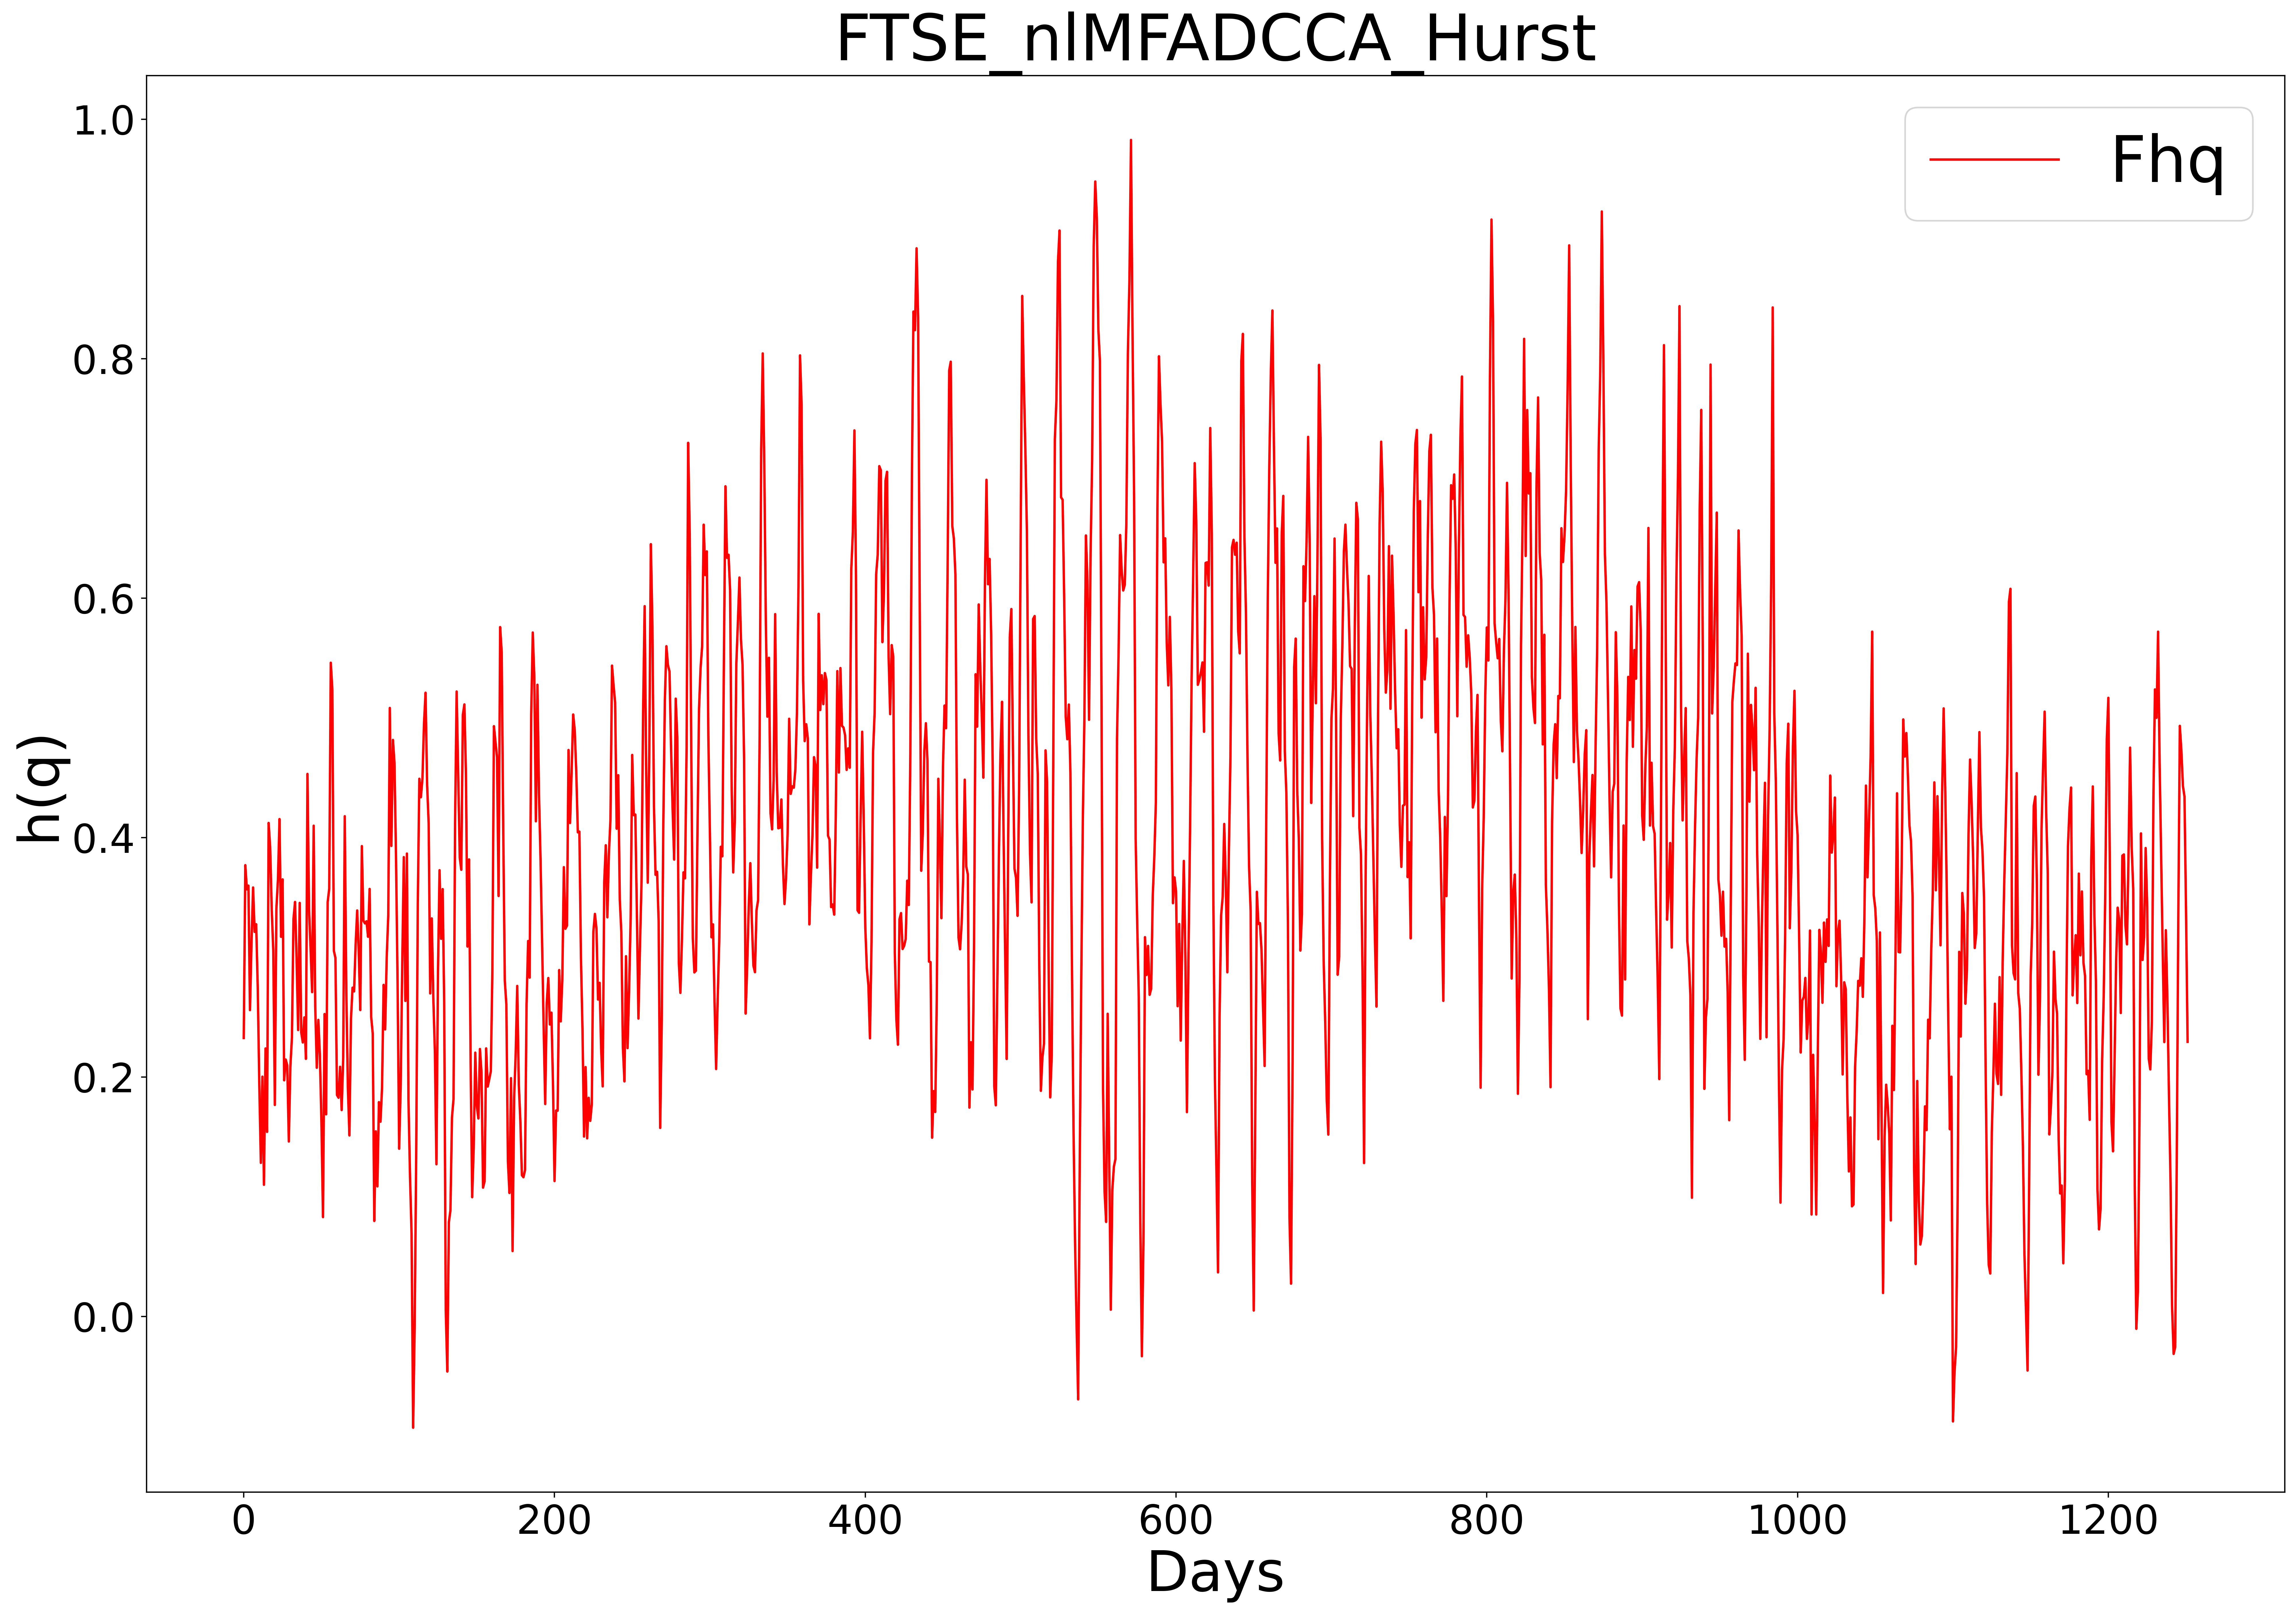

In [13]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst,color='r')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('FTSE_nlMFADCCA_Hurst', fontsize=40)
plt.legend(['Fhq'],fontsize=40)
plt.savefig('./pic/FTSE_pic/FTSE_nlMFADCCA_hurst.png')
plt.show()

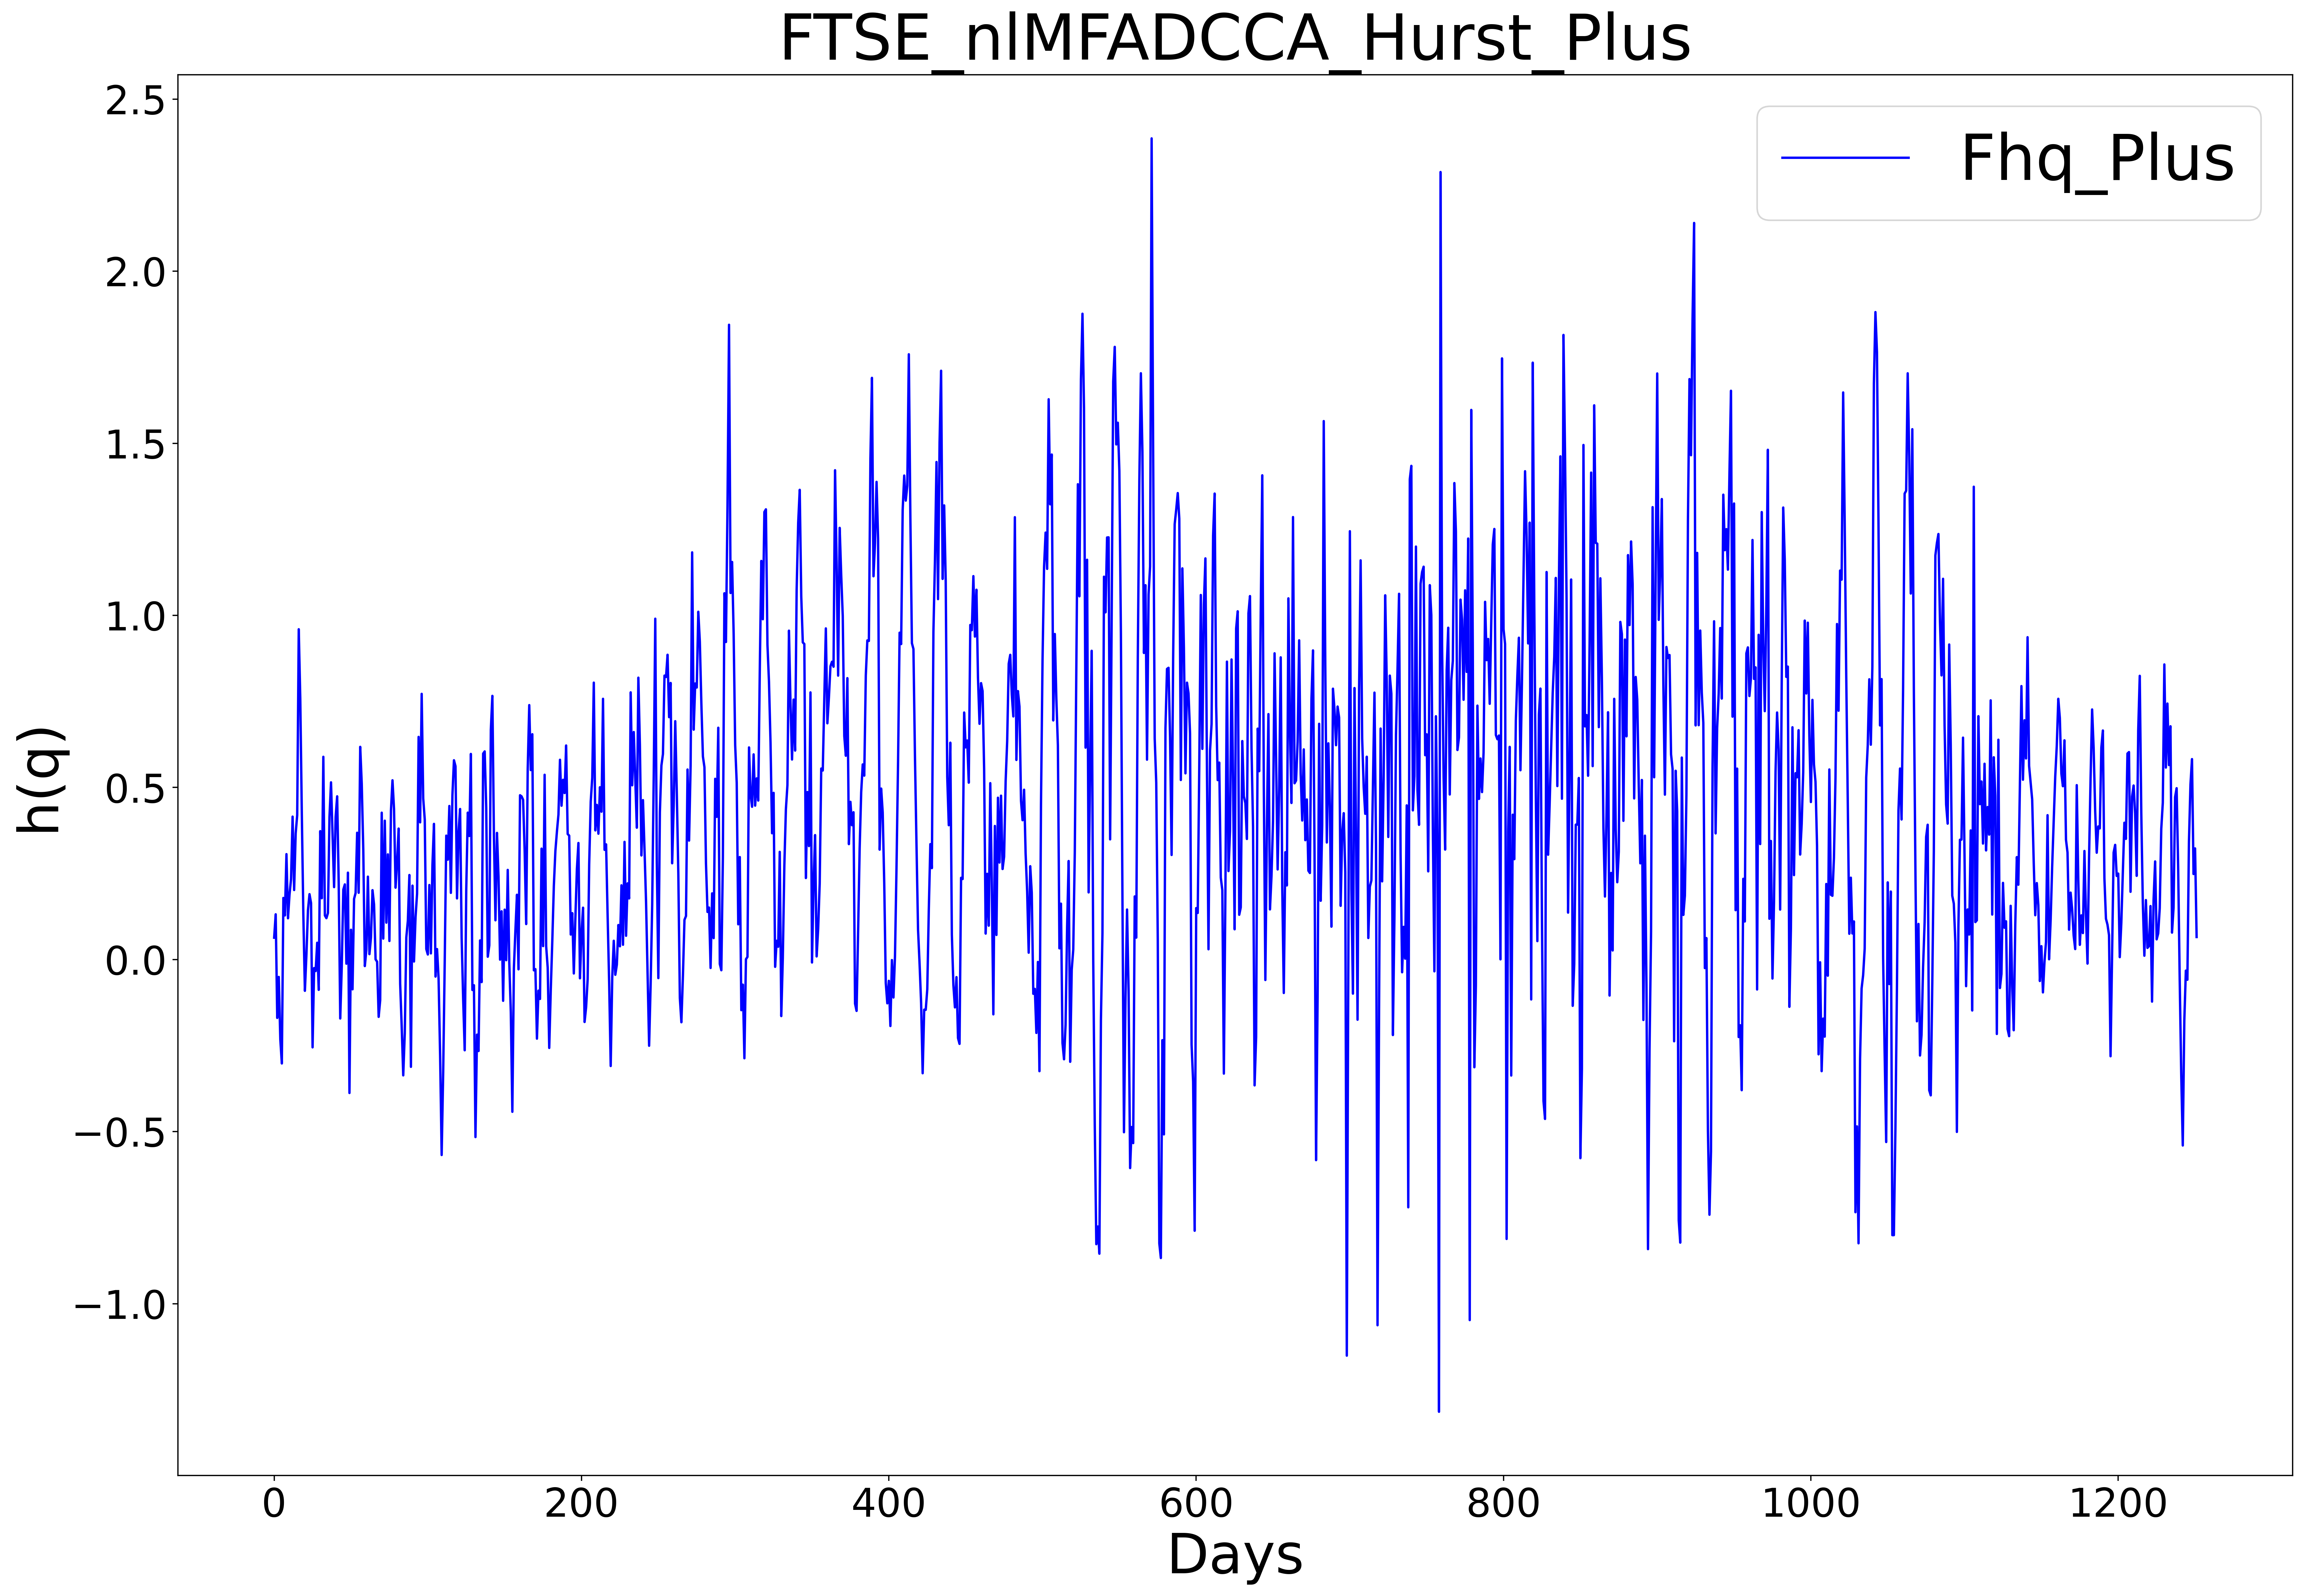

In [14]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_plus,color='b')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('FTSE_nlMFADCCA_Hurst_Plus', fontsize=40)
plt.legend(['Fhq_Plus'],fontsize=40)
plt.savefig('./pic/FTSE_pic/FTSE_nlMFADCCA_hurstplus.png')
plt.show()

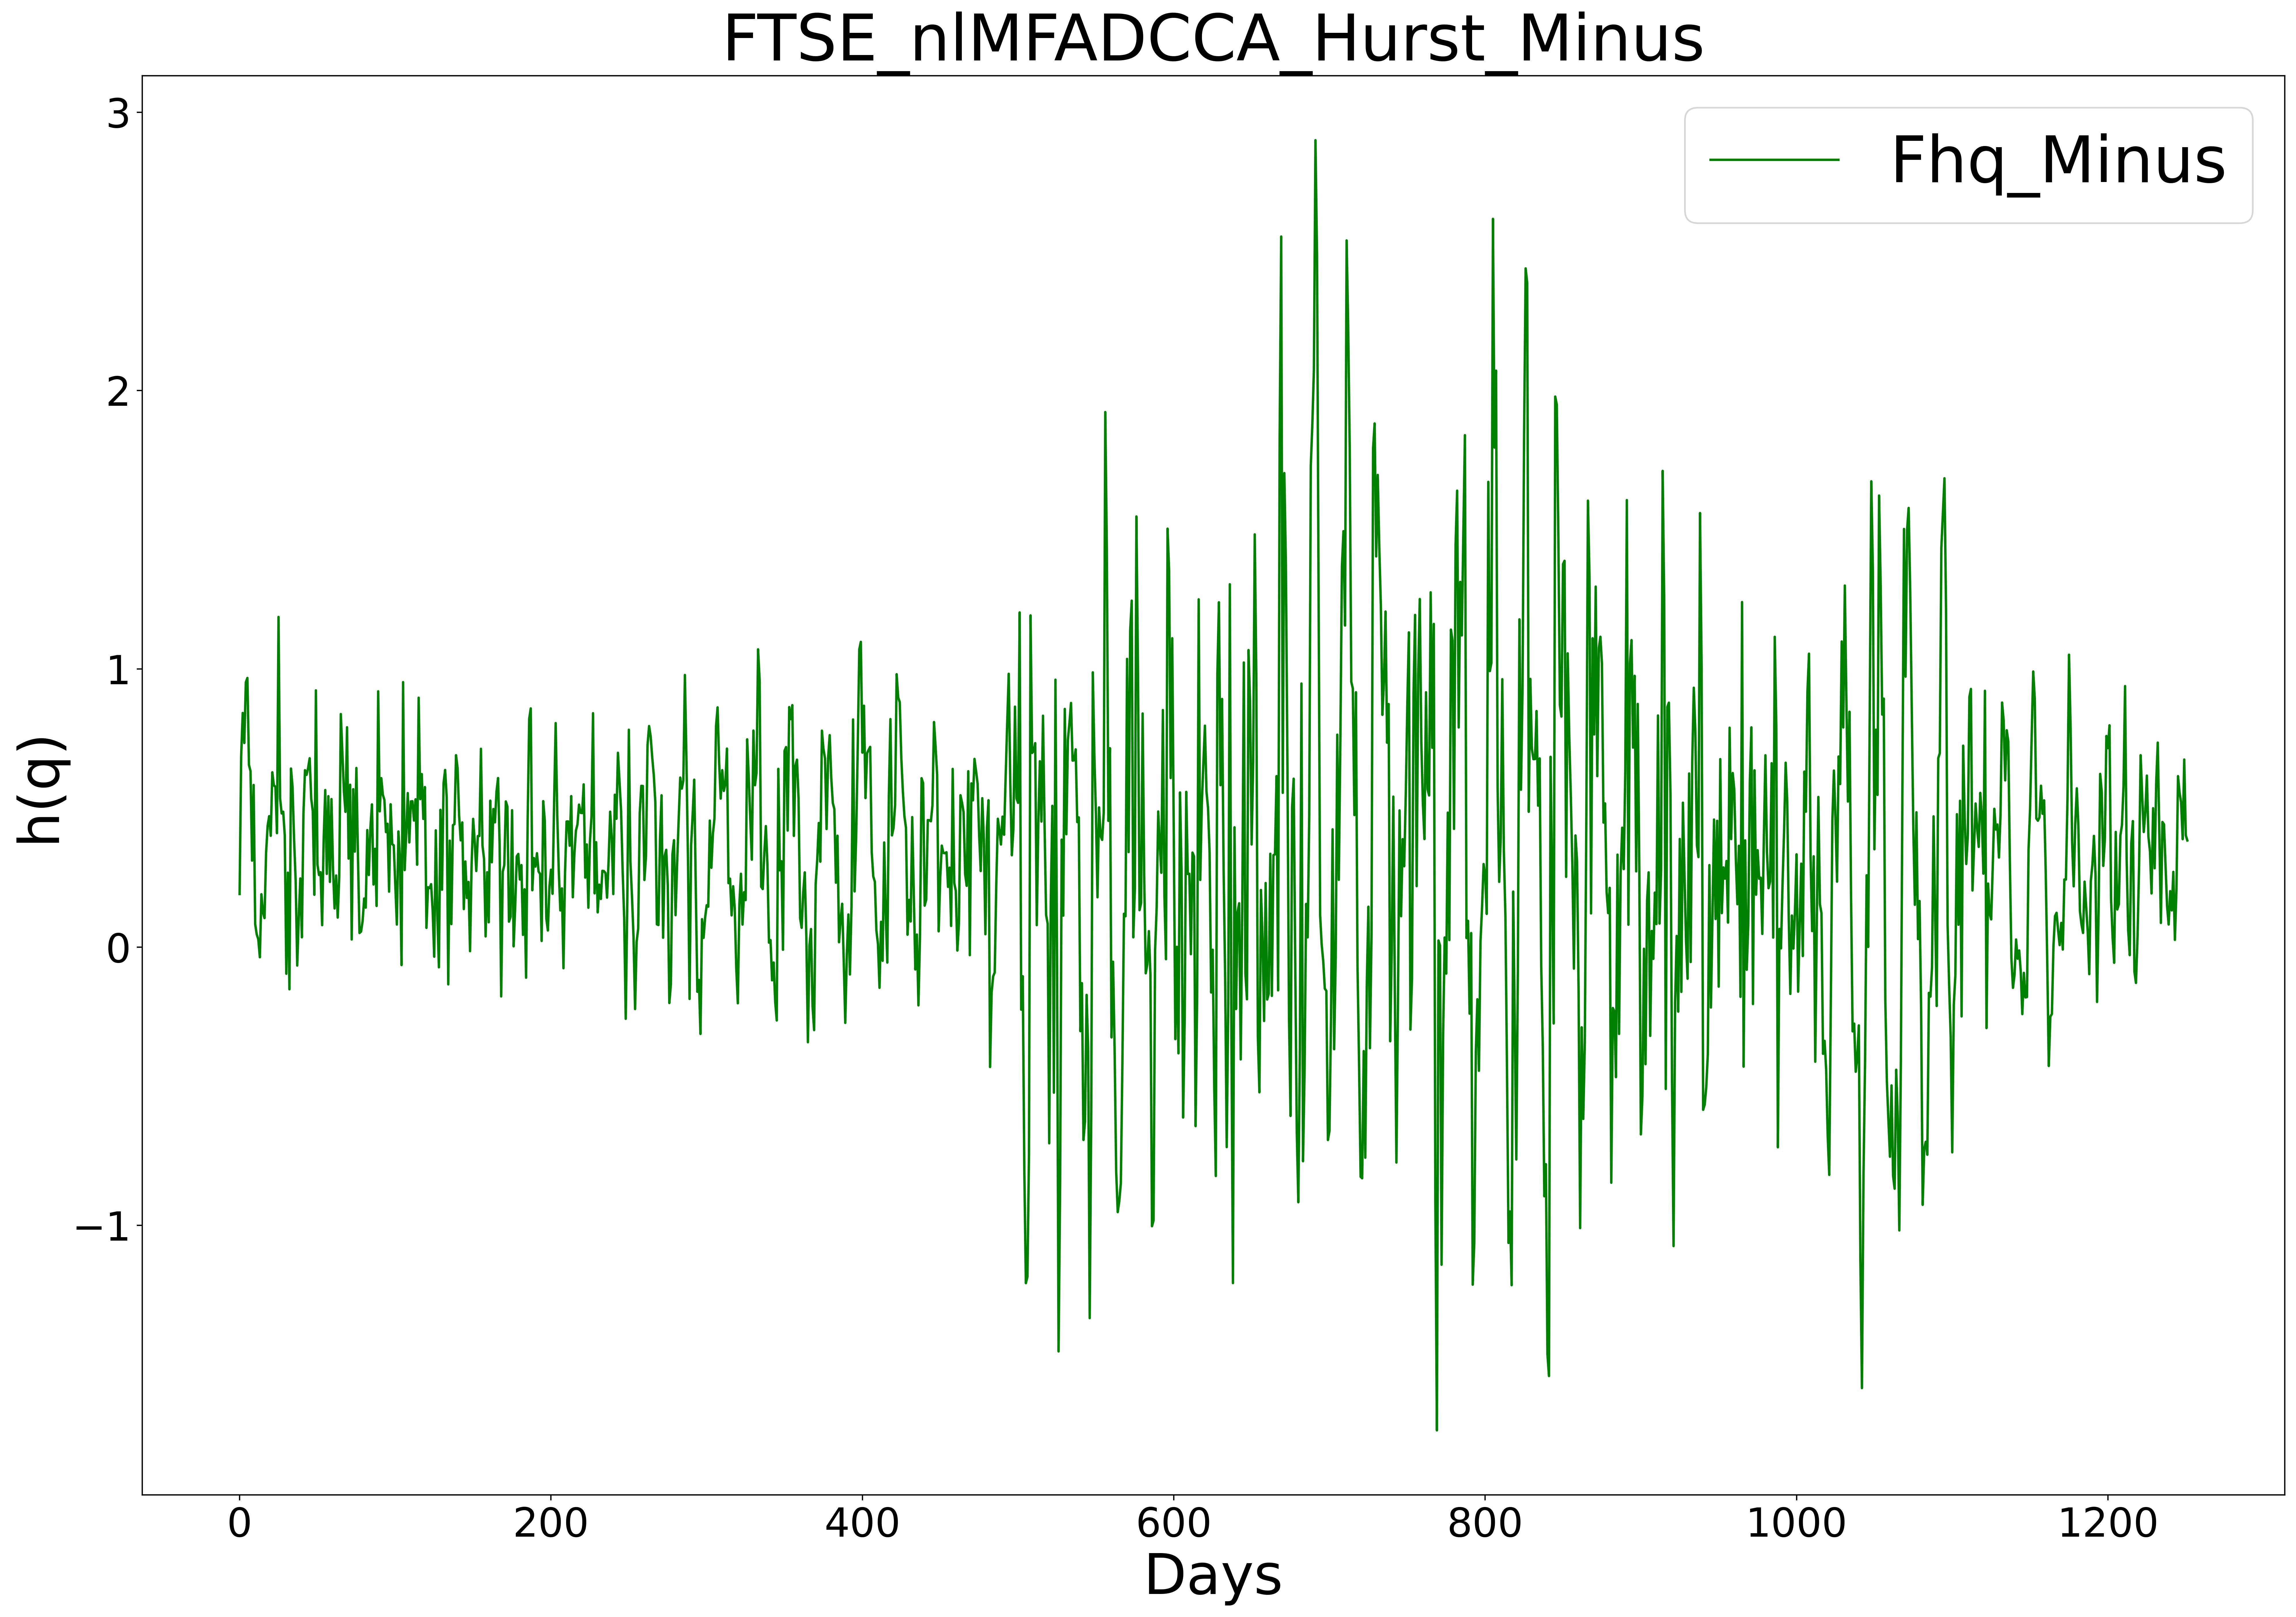

In [15]:
plt.figure(figsize=(24, 16), dpi=400)
plt.plot(hurst_minus,color='g')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Days', fontsize=35)
plt.ylabel('h(q)', fontsize=35)
plt.title('FTSE_nlMFADCCA_Hurst_Minus', fontsize=40)
plt.legend(['Fhq_Minus'],fontsize=40)
plt.savefig('./pic/FTSE_pic/FTSE_nlMFADCCA_hurstminus.png')
plt.show()